# LSTM for Predictive Maintenance

Deep learning is one of the hottest trends in the machine learning space nowadays, and there are many fields and applications where it stands out, such as driverless cars, speech and image recognition, robotics and finance. Deep learning is a set of algorithms that is inspired by the shape of our brain (biological neural networks), and machine learning and cognitive scientists usually refer to it as Artificial Neural Networks (ANN).

Predictive maintenance is also a very popular area where many different techniques are designed to help determine the condition of an equipment in order to predict when maintenance should be performed. In predictive maintenance scenarios, data is collected over time to monitor the state of an equipment with the final goal of finding patterns to predict failures. Among the deep learning methods, Long Short Term Memory [(LSTM)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) networks are especially appealing to the predictive maintenance domain due to the fact that they are very good at learning from sequences. This fact lends itself to their applications using time series data by making it possible to look back for longer periods of time to detect failure patterns. 

In this notebook, we build an LSTM network for the data set and scenerio described at [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) to predict remaining useful life of aircraft engines. In summary, the template uses simulated aircraft sensor values to predict when an aircraft engine will fail in the future so that maintenance can be planned in advance. 

This notebook serves as a tutorial for beginners looking to apply deep learning in predictive maintenance domain and uses a simple scenario where only one data source (sensor values) is used to make predictions. In more advanced predictive maintenance scenarios such as in [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1), there are many other data sources (i.e. historical maintenance records, error logs, machine and operator features etc.) which may require different types of treatments to be used in the deep learning networks. Since predictive maintenance is not a typical domain for deep learning, its application is an open area of research. 

This notebook uses [keras](https://keras.io/) deep learning library with Microsoft Cognitive Toolkit [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/Using-CNTK-with-Keras) as backend.


## Data Aquisition¶
The data aquisiton notebook will download the simulated predicitive maintenance data sets from a public Azure Blob Storage.

In [5]:
import keras

In [6]:
# import the libraries
import os
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
from scipy import stats

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

## Download simulated data sets
We will be reusing the raw simulated data files from another tutorial. The notebook automatically downloads these files stored at http://azuremlsamples.azureml.net/templatedata/

The three data files are:

    * PM_train.txt
    * PM_test.txt
    * PM_truth.txt
    
This notebook does some preliminary cleanup, creates a summary graphic for each data set to verify the data download, and stores the resulting data sets in the Azure blob container created in the previous section.

In [7]:
# The raw train data is stored on Azure Blob here:
basedataurl = "http://azuremlsamples.azureml.net/templatedata/"

## Data Ingestion
In the following section, we ingest the training, test and ground truth datasets from azure storage. The training data consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. The testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs. Finally, the ground truth data provides the number of remaining working cycles for the engines in the testing data. You can find more details about the type of data used for this notebook at [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3).

In [8]:
# Load raw data from Azure blob
train_df = 'PM_train.txt'

# Download the file once, and only once.
if not os.path.isfile(train_df):
    urllib.request.urlretrieve(basedataurl+train_df, train_df)

In [9]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [10]:
# Load raw data from Azure blob
test_df = 'PM_test.txt'

# Download the file once, and only once.
if not os.path.isfile(test_df):
    urllib.request.urlretrieve(basedataurl+test_df, test_df)

In [11]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [12]:
# Load raw data from Azure blob
truth_df = 'PM_truth.txt'

# Download the file once, and only once.
if not os.path.isfile(truth_df):
    urllib.request.urlretrieve(basedataurl+truth_df, truth_df)

In [13]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## Data Preprocessing
First step is to generate labels for the training data which are Remaining Useful Life (RUL), label1 and label2 as was done in the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3). Here, we will only make use of "label1" for binary clasification, while trying to answer the question: is a specific engine going to fail within w1 cycles?

In [14]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [15]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) , cycle column is also used for training so we will also include the cycle column. Here, we normalize the columns in the training data.

In [16]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization applied on the training data. 

In [17]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Next, we use the ground truth dataset to generate labels for the test data.

In [18]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [19]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [20]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


In the rest of the notebook, we train an LSTM network.

## Modelling

The traditional predictive maintenance machine learning models are based on feature engineering which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenario and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering.

When using LSTMs in the time-series domain, one important parameter to pick is the sequence length which is the window for LSTMs to look back. This may be viewed as similar to picking window_size = 5 cycles for calculating the rolling features in the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) which are rolling mean and rolling standard deviation for 21 sensor values. The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

One critical advantage of LSTMs is their ability to remember from long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. For example, computing rolling averages over a window size of 50 cycles may lead to loss of information due to smoothing and abstracting of values over such a long period, istead, using all 50 values as input may provide better results. While feature engineering over large window sizes may not make sense, LSTMs are able to use larger window sizes and use all the information in the window as input. Below, we illustrate the approach.

In [21]:
# pick a large window size of 50 cycles
sequence_length = 50

Let's first look at an example of the sensor values 50 cycles prior to the failure for engine id 3. We will be feeding LSTM network this type of data for each time step for each engine id. 

In [26]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

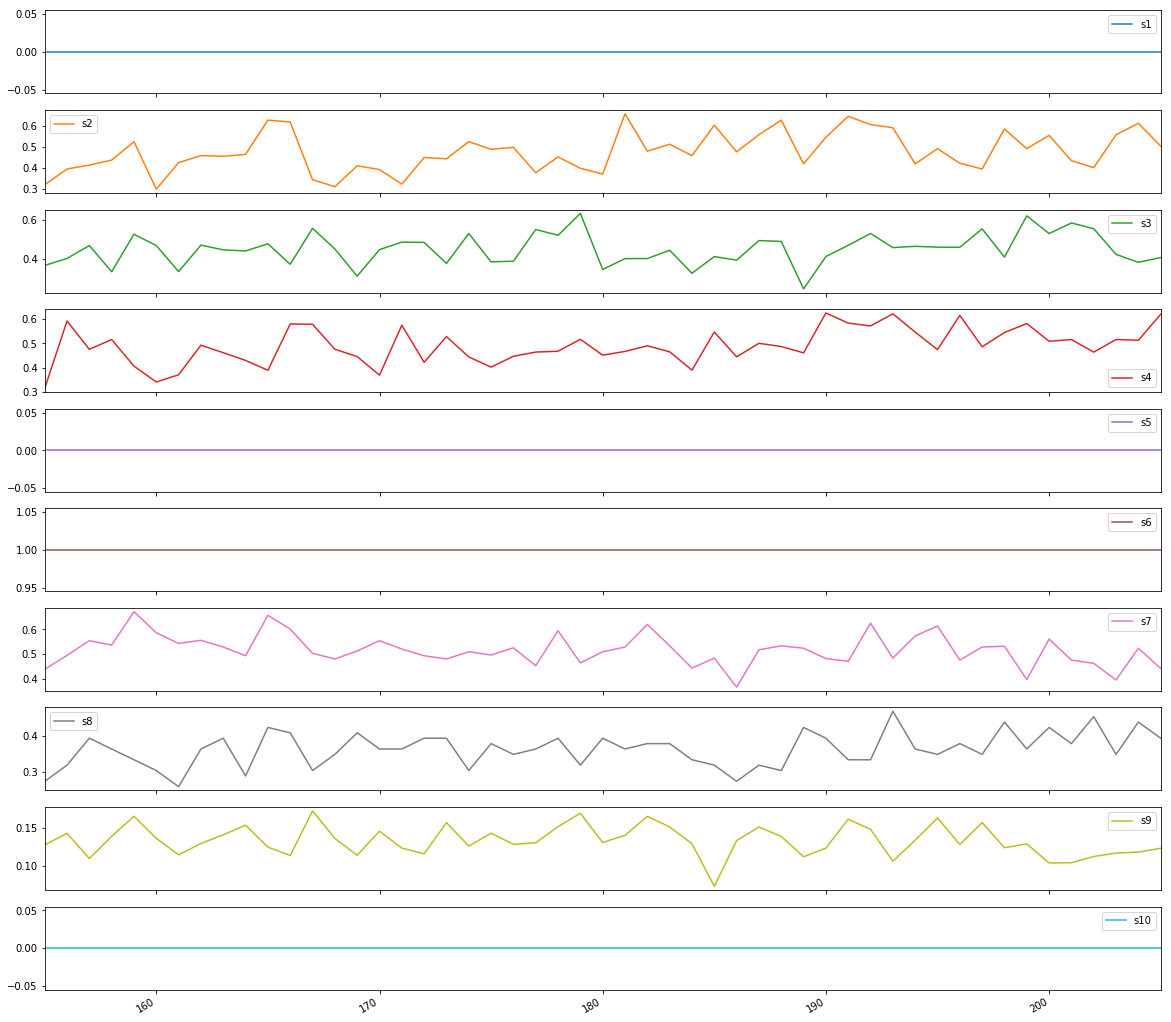

In [27]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

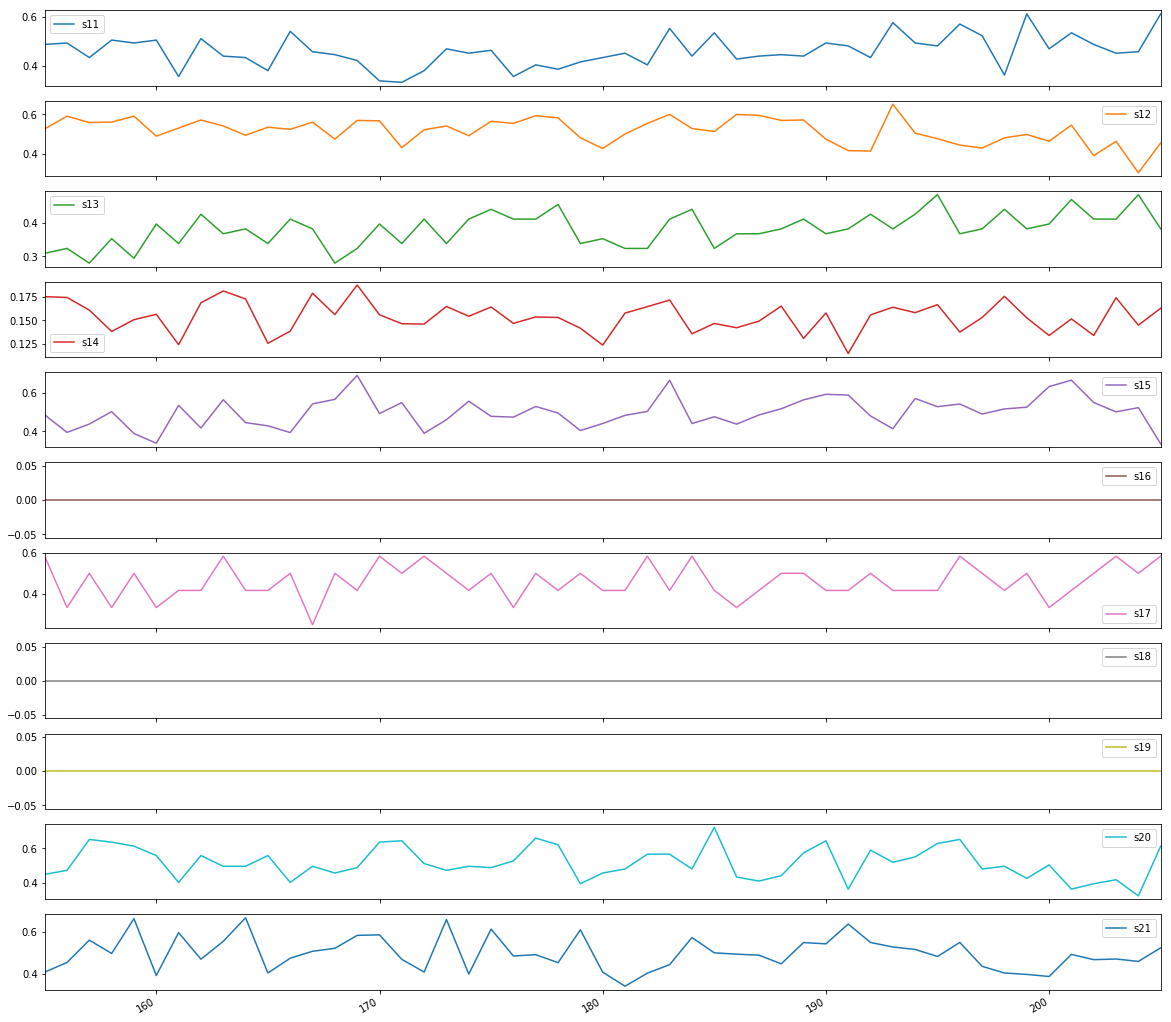

In [28]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

[Keras LSTM](https://keras.io/layers/recurrent/) layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step. 

In [22]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [23]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
input_features = sensor_cols + sequence_cols
input_features
sequence_cols.extend(sensor_cols)

In [24]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [29]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [30]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [31]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM Network
Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.

In [32]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 55s - loss: 0.2626 - acc: 0.8914 - val_loss: 0.1414 - val_acc: 0.9425
Epoch 2/10
14849/14849 [==============================] - 55s - loss: 0.1052 - acc: 0.9563 - val_loss: 0.1342 - val_acc: 0.9386
Epoch 3/10
14849/14849 [==============================] - 55s - loss: 0.0833 - acc: 0.9657 - val_loss: 0.1049 - val_acc: 0.9425
Epoch 4/10
14849/14849 [==============================] - 54s - loss: 0.0748 - acc: 0.9680 - val_loss: 0.0542 - val_acc: 0.9783
Epoch 5/10
14849/14849 [==============================] - 52s - loss: 0.0651 - acc: 0.9732 - val_loss: 0.0336 - val_acc: 0.9872
Epoch 6/10
14849/14849 [==============================] - 49s - loss: 0.0659 - acc: 0.9727 - val_loss: 0.0711 - val_acc: 0.9770
Wall time: 5min 26s


In [35]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 17s    
Accurracy: 0.9603992078638482


In [36]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

15600/15631 [============================>.] - ETA: 0sConfusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12475,    56],
       [  563,  2537]], dtype=int64)

In [37]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.978403393752 
 recall =  0.818387096774


# Save the model

In [38]:
import pickle
from sklearn import datasets 
#saved_model = model

# save model
model.save(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']+'pdmrfull.model')
print("Model saved")

Model saved


# Model operationalization & Deployment

In this script, a model is saved as a .model file along with the relevant scheme for deployment. The functions are first tested locally before operationalizing the model using Azure Machine Learning Model Management environment for use in production in realtime.

In [39]:
## setup our environment by importing required libraries
import json
import os
import shutil
import time
from sklearn.pipeline import Pipeline
from azureml.api.schema.dataTypes import DataTypes
from azureml.api.schema.sampleDefinition import SampleDefinition
from azureml.api.realtime.services import generate_schema

# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

# For logging model evaluation parameters back into the
# AML Workbench run history plots.
import logging
from azureml.logging import get_azureml_logger

amllog = logging.getLogger("azureml")
amllog.level = logging.INFO

# Turn on cell level logging.
%azureml history on
%azureml history show

# Time the notebook execution. 
# This will only make sense if you "Run all cells"
tic = time.time()

logger = get_azureml_logger() # logger writes to AMLWorkbench runtime view

History logging enabled
History logging is enabled


## Define init and run functions
Start by defining the init() and run() functions as shown in the cell below. Then write them to the score.py file. This file will load the model, perform the prediction, and return the result.

The init() function initializes your web service, loading in any data or models that you need to score your inputs. In the example below, we load in the trained model. This command is run when the Docker container containing your service initializes.
The run() function defines what is executed on a scoring call. In our simple example, we simply load in the input as a data frame, and run our pipeline on the input, and return the prediction.

In [40]:
def init():
    # read in the model file
    from sklearn.pipeline import Pipeline
    global pipeline
    
    pipeline = PipelineModel.load(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']+'pdmrfull.model')

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]    
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
        
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    seq_array.shape

def run(input_df):
    import json
    response = ''
    try:
        # function to reshape features into (samples, time steps, features)
        
        #Get prediction results for the dataframe
        # pick the feature columns 
        #sensor_cols = ['s' + str(i) for i in range(1,22)]
        #sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
        #input_features = sensor_cols + sequence_cols
 
        # Vectorize as in model building
        #va = VectorAssembler(inputCols=(input_features), outputCol='features')
        #data = va
        score = pipeline.transform(seq_array)
        predictions = score.collect()   

   
        # Get each scored result
        preds = [str(x['prediction']) for x in predictions]
        response = ",".join(preds)
    except Exception as e:
        print("Error: {0}", str(e))
        return (str(e))
    
        # Return results
        print(json.dumps(response))
        return json.dumps(response)

### Create schema and schema file
Create a schema for the input to the web service and generate the schema file. This will be used to create a Swagger file for your web service which can be used to discover its input and sample data when calling it.

In [41]:
# define the input data frame
inputs = {"input_df": SampleDefinition(DataTypes.PANDAS, train_df)}
generate_schema(run_func=run, inputs=inputs, filepath='service_schema.json')

{'input': {'input_df': {'internal': 'gANjYXp1cmVtbC5hcGkuc2NoZW1hLnBhbmRhc1V0aWwKUGFuZGFzU2NoZW1hCnEAKYFxAX1xAihYDAAAAGNvbHVtbl90eXBlc3EDXXEEKGNudW1weQpkdHlwZQpxBVgCAAAAaThxBksASwGHcQdScQgoSwNYAQAAADxxCU5OTkr/////Sv////9LAHRxCmJoCGgFWAIAAABmOHELSwBLAYdxDFJxDShLA2gJTk5OSv////9K/////0sAdHEOYmgNaA1oDWgNaA1oDWgNaA1oDWgNaA1oDWgNaA1oDWgNaA1oDWgNaA1oDWgNaA1oCGgFWAIAAABpNHEPSwBLAYdxEFJxEShLA2gJTk5OSv////9K/////0sAdHESYmgRaA1lWAoAAABzY2hlbWFfbWFwcRN9cRQoWAMAAABzMjFxFWgNWAIAAABzMXEWaA1YAgAAAHM5cRdoDVgCAAAAaWRxGGgIWAMAAABzMjBxGWgNWAIAAABzN3EaaA1YAwAAAHMxOHEbaA1YAwAAAHMxOXEcaA1YBQAAAGN5Y2xlcR1oCFgCAAAAczhxHmgNWAMAAABzMTNxH2gNWAMAAABzMTFxIGgNWAIAAABzNXEhaA1YAwAAAHMxMnEiaA1YAwAAAFJVTHEjaAhYAwAAAHMxN3EkaA1YAwAAAHMxMHElaA1YCAAAAHNldHRpbmcycSZoDVgCAAAAczRxJ2gNWAIAAABzNnEoaA1YAwAAAHMxNXEpaA1YBgAAAGxhYmVsMnEqaBFYAgAAAHMycStoDVgGAAAAbGFiZWwxcSxoEVgKAAAAY3ljbGVfbm9ybXEtaA1YAwAAAHMxNnEuaA1YAgAAAHMzcS9oDVgIAAAAc2V0dGluZzFxMGgNWAMAAABzMTRxMWgNWAgAAABzZXR0aW5nM3EyaA11WAwAAABjb2x1bW5fbmFtZXNxM11xNChoGGgdaDBoJmg

In [43]:
import imp
import score
imp.reload(score)

<module 'score' from 'C:\\Users\\lazzeri\\AppData\\Local\\Temp\\azureml_runs\\lstm_1510772318027\\score.py'>

In [44]:
score.init()
score.run(train_df)

'"        id  cycle  setting1  setting2  setting3   s1        s2        s3  \\\\\\n0        1      1  0.459770  0.166667       0.0  0.0  0.183735  0.406802   \\n1        1      2  0.609195  0.250000       0.0  0.0  0.283133  0.453019   \\n2        1      3  0.252874  0.750000       0.0  0.0  0.343373  0.369523   \\n3        1      4  0.540230  0.500000       0.0  0.0  0.343373  0.256159   \\n4        1      5  0.390805  0.333333       0.0  0.0  0.349398  0.257467   \\n5        1      6  0.252874  0.416667       0.0  0.0  0.268072  0.292784   \\n6        1      7  0.557471  0.583333       0.0  0.0  0.382530  0.463920   \\n7        1      8  0.304598  0.750000       0.0  0.0  0.406627  0.259865   \\n8        1      9  0.545977  0.583333       0.0  0.0  0.274096  0.434707   \\n9        1     10  0.310345  0.583333       0.0  0.0  0.150602  0.440375   \\n10       1     11  0.603448  0.250000       0.0  0.0  0.322289  0.233486   \\n11       1     12  0.591954  0.666667       0.0  0.0  0.256